In [68]:
import json, pickle
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from seqeval.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter


In [69]:
from collections import Counter

data = []

with open("../dataset/dataset_ner_srl.tsv", encoding="utf-8") as f:
    tokens, ner_labels, srl_labels = [], [], []
    
    for line in f:
        line = line.strip()
        if not line:
            if tokens:
                data.append({
                    "tokens": tokens,
                    "labels_ner": ner_labels,
                    "labels_srl": srl_labels
                })
                tokens, ner_labels, srl_labels = [], [], []
        else:
            token, ner, srl = line.split("\t")
            tokens.append(token)
            ner_labels.append(ner)
            srl_labels.append(srl)

# Preprocessing
sentences = [[tok.lower() for tok in item["tokens"]] for item in data]
labels_ner = [item["labels_ner"] for item in data]
labels_srl = [item["labels_srl"] for item in data]

# Hitung total label SRL
srl_counter = Counter()
for srl_sequence in labels_srl:
    srl_counter.update(srl_sequence)

print("Distribusi label SRL:")
for label, count in srl_counter.most_common():
    print(f"{label}: {count}")

# Hitung total label NER
ner_counter = Counter()
for ner_sequence in labels_ner:
    ner_counter.update(ner_sequence)

print("\nDistribusi label NER:")
for label, count in ner_counter.most_common():
    print(f"{label}: {count}")

# Total kalimat dan token
total_kalimat = len(data)
total_token = sum(len(item["tokens"]) for item in data)

print("\nTotal kalimat:", total_kalimat)
print("Total token:", total_token)


Distribusi label SRL:
ARG1: 2597
O: 1487
V: 943
ARGM-LOC: 781
ARGM-TMP: 736
ARG0: 685
ARG2: 445
ARGM-MNR: 221
ARGM-CAU: 113
ARGM-MOD: 90
ARGM-ADV: 29
ARGM-NEG: 18
ARGM-PRP: 18
ARGM-SRC: 16
ARGM-COM: 16
ARGM-PRD: 13
ARGM-DIR: 13
ARG3: 12
ARGM-DIS: 8
ARGM-BNF: 6
I-TIME: 4
ARGM-FRQ: 2
ARGM-ORD: 2
ARGM-EXT: 2
ARGM-REC: 2
B-TIME: 2
Osoe: 1
ARGM-ADJ: 1
ARGM-EX: 1

Distribusi label NER:
O: 5782
B-LOC: 551
I-QUANT: 224
B-QUANT: 203
I-LOC: 202
I-EVENT: 151
I-DATE: 146
B-EVENT: 143
B-DATE: 139
I-PER: 121
B-TIME: 113
B-PER: 110
I-TIME: 98
B-ETH: 83
I-ETH: 65
B-ORG: 60
I-ORG: 24
B-MISC: 22
B-RES: 8
B-MIN: 6
I-MISC: 4
I-TERM: 3
B-REL: 2
B-TERM: 2
I-RES: 2

Total kalimat: 799
Total token: 8264


In [70]:
# tagging 
words = sorted({w for s in sentences for w in s})
ner_tags = sorted({t for seq in labels_ner for t in seq})
srl_tags = sorted({t for seq in labels_srl for t in seq})

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["PAD"], word2idx["UNK"] = 0, 1

tag2idx_ner = {t: i for i, t in enumerate(ner_tags)}
tag2idx_srl = {t: i for i, t in enumerate(srl_tags)}
idx2tag_ner = {i: t for t, i in tag2idx_ner.items()}
idx2tag_srl = {i: t for t, i in tag2idx_srl.items()}

In [71]:
# encoding

X = [[word2idx.get(w, word2idx["UNK"]) for w in s] for s in sentences]
y_ner = [[tag2idx_ner[t] for t in seq] for seq in labels_ner]
y_srl = [[tag2idx_srl[t] for t in seq] for seq in labels_srl]

maxlen = max(len(s) for s in sentences)
print(maxlen)

X = pad_sequences(X, maxlen=maxlen, padding="post", value=word2idx["PAD"])
y_ner = pad_sequences(y_ner, maxlen=maxlen, padding="post", value=tag2idx_ner["O"])
y_srl = pad_sequences(y_srl, maxlen=maxlen, padding="post", value=tag2idx_srl["O"])

y_ner = [to_categorical(seq, num_classes=len(tag2idx_ner)) for seq in y_ner]
y_srl = [to_categorical(seq, num_classes=len(tag2idx_srl)) for seq in y_srl]

X = np.array(X)
y_ner = np.array(y_ner)
y_srl = np.array(y_srl)

39


In [72]:
X_train, X_test, y_ner_train, y_ner_test, y_srl_train, y_srl_test = train_test_split(
    X, y_ner, y_srl,            
    test_size=0.20,             
    random_state=42,
    shuffle=True            
)

In [ ]:
input_layer = Input(shape=(maxlen,))
embed = Embedding(len(word2idx), 64)(input_layer)
bilstm = Bidirectional(LSTM(64, return_sequences=True))(embed)

ner_output = TimeDistributed(
    Dense(len(tag2idx_ner), activation="softmax"), name="ner_output"
)(bilstm)
srl_output = TimeDistributed(
    Dense(len(tag2idx_srl), activation="softmax"), name="srl_output"
)(bilstm)

model = Model(inputs=input_layer, outputs=[ner_output, srl_output])
model.compile(
    optimizer="adam",
    loss={
        "ner_output": "categorical_crossentropy",
        "srl_output": "categorical_crossentropy",
    },
    metrics={
        "ner_output": [CategoricalAccuracy(name="accuracy")],
        "srl_output": [CategoricalAccuracy(name="accuracy")],
    },
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                     patience=3,
                                     restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras", monitor="val_loss", save_best_only=True)
]

model.summary()
history = model.fit(
    X_train, {"ner_output": y_ner_train, "srl_output": y_srl_train}, 
    validation_data=(X_test, {"ner_output": y_ner_test, "srl_output": y_srl_test}),
    batch_size=2,
    epochs=30,
    verbose=1
)

# ---------- 6. Simpan artefak ----------
model.save("multi_task_lstm_ner_srl_model.keras")
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)
with open("tag2idx_ner.pkl", "wb") as f:
    pickle.dump(tag2idx_ner, f)
with open("tag2idx_srl.pkl", "wb") as f:
    pickle.dump(tag2idx_srl, f)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 39, 64)    │    130,816 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 39, 128)   │     66,048 │ embedding_6[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_output          │ (None, 39, 25)    │      3,225 │ bidirectional_6[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_output          │ (None, 39, 29)    │      3,741 │ bidirectional_6[… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 203,830 (796.21 KB)

 Trainable params: 203,830 (796.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 1.8462 - ner_output_accuracy: 0.9063 - ner_output_loss: 0.7988 - srl_output_accuracy: 0.8035 - srl_output_loss: 1.0474 - val_loss: 0.8543 - val_ner_output_accuracy: 0.9196 - val_ner_output_loss: 0.3470 - val_srl_output_accuracy: 0.8340 - val_srl_output_loss: 0.5073
Epoch 2/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7499 - ner_output_accuracy: 0.9186 - ner_output_loss: 0.3147 - srl_output_accuracy: 0.8535 - srl_output_loss: 0.4352 - val_loss: 0.6488 - val_ner_output_accuracy: 0.9325 - val_ner_output_loss: 0.2552 - val_srl_output_accuracy: 0.8750 - val_srl_output_loss: 0.3936
Epoch 3/30
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.5438 - ner_output_accuracy: 0.9362 - ner_output_loss: 0.2241 - srl_output_accuracy: 0.9011 - srl_output_loss: 0.3197 - val_loss: 0.5199 - val_ner_output_accuracy: 0.9534 - val_ner_output_loss: 0.1888 - val_srl_output_accuracy: 0.9000 - val_srl_output_loss: 0.3311
Epoch 4/30
320/320 ━━

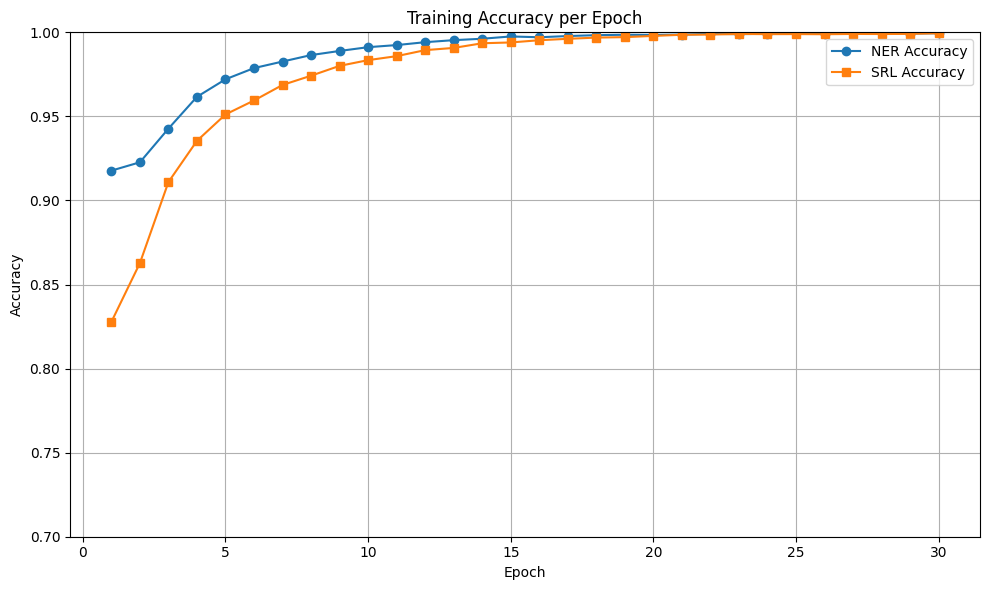

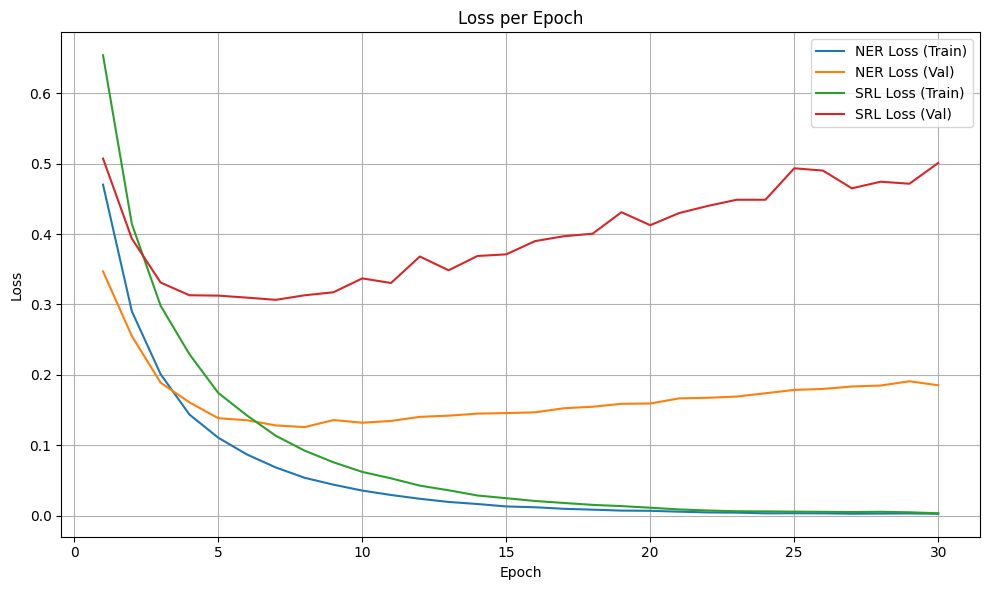

In [74]:

ner_accuracy = history.history['ner_output_accuracy']
srl_accuracy = history.history['srl_output_accuracy']
epochs = list(range(1, len(ner_accuracy) + 1))

ner_loss = history.history['ner_output_loss']
srl_loss = history.history['srl_output_loss']
val_ner_loss = history.history['val_ner_output_loss']
val_srl_loss = history.history['val_srl_output_loss']


# --------- Plot Accuracy ---------
plt.figure(figsize=(10, 6))
plt.plot(epochs, ner_accuracy, marker='o', label='NER Accuracy')
plt.plot(epochs, srl_accuracy, marker='s', label='SRL Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot.png")  # Simpan sebagai file gambar
plt.show()

# --------- Plot Loss ---------
plt.figure(figsize=(10, 6))
plt.plot(epochs, ner_loss, label='NER Loss (Train)')
plt.plot(epochs, val_ner_loss, label='NER Loss (Val)')
plt.plot(epochs, srl_loss, label='SRL Loss (Train)')
plt.plot(epochs, val_srl_loss, label='SRL Loss (Val)')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot.png")  
plt.show()


In [75]:
# evaluation

print("Metrics names:", model.metrics_names)


results = model.evaluate(
    X_test,
    {"ner_output": y_ner_test, "srl_output": y_srl_test},
    verbose=0
)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")
    
def token_level_accuracy(y_true, y_pred):
    total, correct = 0, 0
    for true_seq, pred_seq in zip(y_true, y_pred):
        for t, p in zip(true_seq, pred_seq):
            if t.sum() == 0:  # skip PAD
                continue
            total += 1
            if t.argmax() == p.argmax():
                correct += 1
    return correct / total


def decode(pred, true, idx2tag):
    out_true, out_pred = [], []
    for p_seq, t_seq in zip(pred, true):
        t_labels, p_labels = [], []
        for p_tok, t_tok in zip(p_seq, t_seq):
            if t_tok.sum() == 0:          # token PAD → lewati
                continue
            t_labels.append(idx2tag[t_tok.argmax()])
            p_labels.append(idx2tag[p_tok.argmax()])
        out_true.append(t_labels)
        out_pred.append(p_labels)
    return out_true, out_pred

# prediksi hanya pada test set
y_pred_ner, y_pred_srl = model.predict(X_test, verbose=0)

true_ner, pred_ner = decode(y_pred_ner, y_ner_test, idx2tag_ner)

acc_ner = token_level_accuracy(y_ner_test, y_pred_ner)
acc_srl = token_level_accuracy(y_srl_test, y_pred_srl)

print(f"[NER] Token-level Accuracy: {acc_ner:.2f}")
print(f"[SRL] Token-level Accuracy: {acc_srl:.2f}")
# print(idx2tag_ner)
print("[NER] Classification Report (test set):")
print(classification_report(true_ner, pred_ner, digits=2))


Metrics names: ['loss', 'compile_metrics', 'ner_output_loss', 'srl_output_loss']
loss: 0.6862505674362183
compile_metrics: 0.18517984449863434
ner_output_loss: 0.5010706782341003
srl_output_loss: 0.9668269157409668
[NER] Token-level Accuracy: 0.97
[SRL] Token-level Accuracy: 0.92
[NER] Classification Report (test set):
              precision    recall  f1-score   support

        DATE       0.45      0.56      0.50        18
         ETH       0.84      0.80      0.82        20
       EVENT       0.47      0.58      0.52        26
         LOC       0.63      0.74      0.68       121
        MISC       0.00      0.00      0.00         3
         ORG       0.38      0.25      0.30        12
         PER       0.71      0.58      0.64        26
       QUANT       0.77      0.77      0.77        43
         RES       0.00      0.00      0.00         5
        TERM       0.00      0.00      0.00         2
        TIME       0.47      0.42      0.44        19

   micro avg       0.62      

/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
true_srl, pred_srl = decode(y_pred_srl, y_srl_test, idx2tag_srl)
# print(idx2tag_srl)
print("[SRL] Classification Report (test set):")
print(classification_report(true_srl, pred_srl, digits=2))

[SRL] Classification Report (test set):
              precision    recall  f1-score   support

         ADV       0.00      0.00      0.00         6
         BNF       0.00      0.00      0.00         1
         CAU       0.10      0.17      0.12        12
         COM       0.00      0.00      0.00         4
         DIR       0.00      0.00      0.00         0
         LOC       0.42      0.57      0.49        61
         MNR       0.28      0.36      0.32        36
         MOD       0.60      0.71      0.65        17
         NEG       0.50      0.75      0.60         4
         PRD       1.00      0.50      0.67         2
         PRP       0.00      0.00      0.00         3
         RG0       0.68      0.69      0.68        93
         RG1       0.52      0.59      0.55       256
         RG2       0.07      0.06      0.07        47
         SRC       0.00      0.00      0.00         2
        TIME       0.00      0.00      0.00         1
         TMP       0.38      0.45      0.

/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: V seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARGM-LOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/

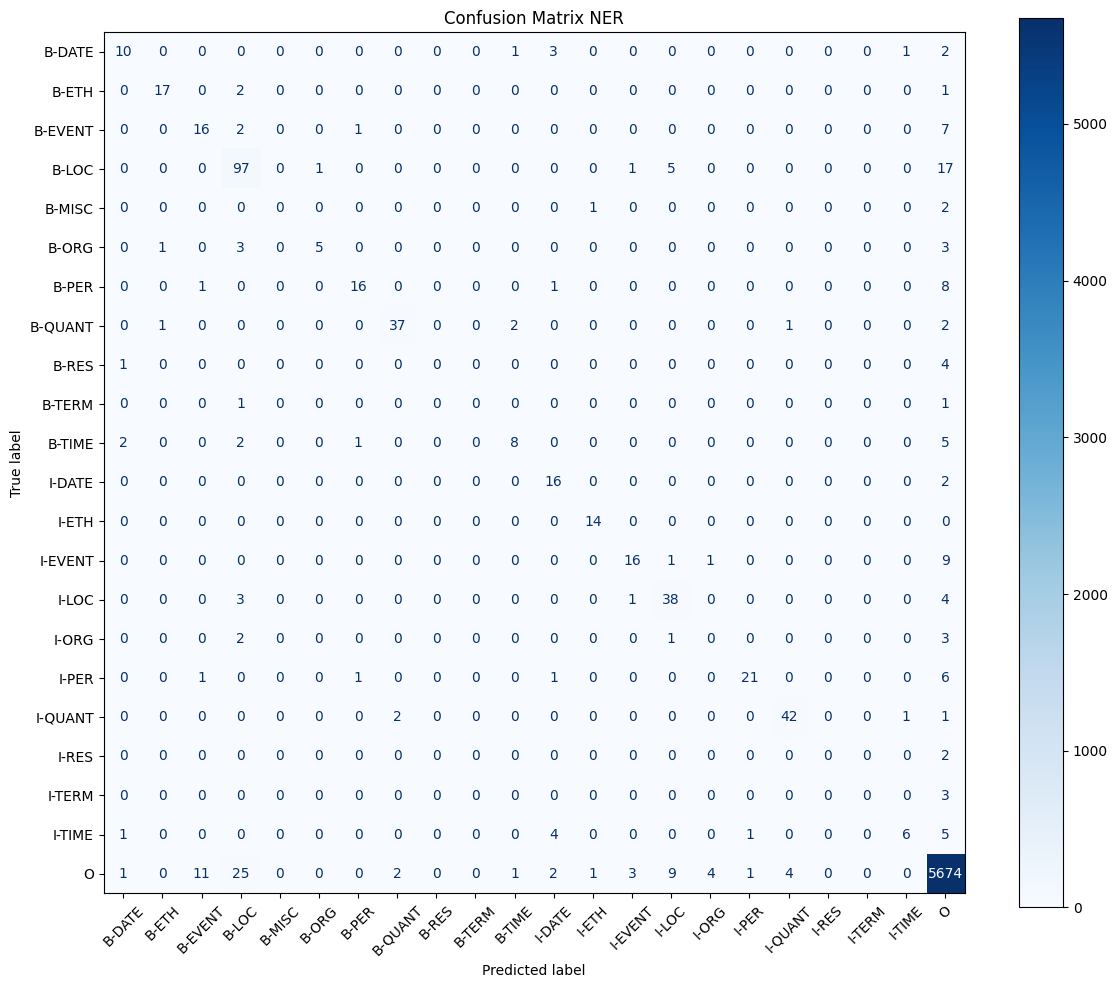

In [77]:
flat_true_ner = [t for seq in true_ner for t in seq]
flat_pred_ner = [p for seq in pred_ner for p in seq]

labels_ner = sorted(list(set(flat_true_ner + flat_pred_ner)))
cm_ner = confusion_matrix(flat_true_ner, flat_pred_ner, labels=labels_ner)

plt.figure(figsize=(12, 10))  

disp = ConfusionMatrixDisplay(confusion_matrix=cm_ner, display_labels=labels_ner)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues, ax=plt.gca())  

plt.title("Confusion Matrix NER")
plt.tight_layout()
plt.show()

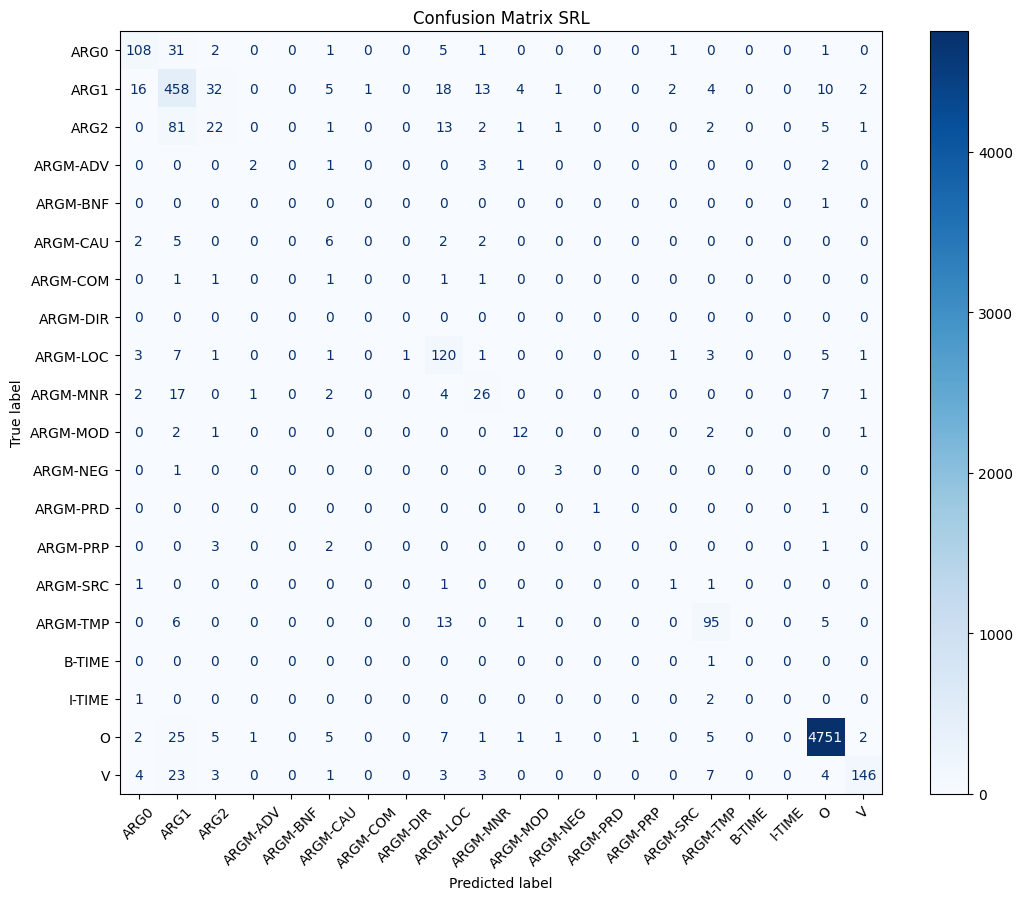

In [78]:
flat_true_srl = [t for seq in true_srl for t in seq]
flat_pred_srl = [p for seq in pred_srl for p in seq]

labels_srl = sorted(list(set(flat_true_srl + flat_pred_srl)))
cm_srl = confusion_matrix(flat_true_srl, flat_pred_srl, labels=labels_srl)

plt.figure(figsize=(11, 9))  

disp = ConfusionMatrixDisplay(confusion_matrix=cm_srl, display_labels=labels_srl)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues, ax=plt.gca())
plt.title("Confusion Matrix SRL")
plt.tight_layout()
plt.show()